In [1]:
from __future__ import print_function
import os
import pickle

from shapely.geometry import LineString

from zipfile import ZipFile
import xml.sax, xml.sax.handler
from pyproj import Proj, transform

import numpy as np
import time
import datetime
from functools import reduce

from sklearn import svm, datasets
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

import scipy.io
import scipy.integrate
from astropy.convolution import convolve, Box1DKernel

from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection, LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.path import Path as mpath
from scipy.optimize import least_squares

from scipy import misc
import glob
from skimage import filters

import pandas as pd
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.options.display.max_columns = 999
pd.options.display.max_rows = 90

np.set_printoptions(threshold=np.nan)

plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
plt.rc('text', usetex=True)

###############
## COMPUTER ##
###############

laptop = False

In [2]:
###############
## FUNCTION DEFS TO PARSE KMZ ##
###############

class PlacemarkHandler(xml.sax.handler.ContentHandler):
    def __init__(self):
        self.inName = False # handle XML parser events
        self.inPlacemark = False
        self.mapping = {} 
        self.buffer = ""
        self.name_tag = ""
        
    def startElement(self, name, attributes):
        if name == "Placemark": # on start Placemark tag
            self.inPlacemark = True
            self.buffer = "" 
        if self.inPlacemark:
            if name == "name": # on start title tag
                self.inName = True # save name text to follow
            
    def characters(self, data):
        if self.inPlacemark: # on text within tag
            self.buffer += data # save text if in title
            
    def endElement(self, name):
        self.buffer = self.buffer.strip('\n\t')
        
        if name == "Placemark":
            self.inPlacemark = False
            self.name_tag = "" #clear current name
        
        elif name == "name" and self.inPlacemark:
            self.inName = False # on end title tag            
            self.name_tag = self.buffer.strip()
            self.mapping[self.name_tag] = {}
        elif self.inPlacemark:
            if name in self.mapping[self.name_tag]:
                self.mapping[self.name_tag][name] += self.buffer
            else:
                self.mapping[self.name_tag][name] = self.buffer
        self.buffer = ""
        
def build_table(mapping):
    sep = ','
        
    output = 'Name' + sep + 'Coordinates\n'
    points = ''
    lines = ''
    shapes = ''
    for key in mapping:
        coord_str = mapping[key]['coordinates'] + sep
        
        if 'LookAt' in mapping[key]: #points
            points += key + sep + coord_str + "\n"
        elif 'LineString' in mapping[key]: #lines
            lines += key + sep + coord_str + "\n"
        else: #shapes
            shapes += key + sep + coord_str + "\n"
    output += points + lines + shapes
    return output

In [4]:
#parse the kmz
kmz = ZipFile('/home/andrew/Documents/Python/WS_DEM/upwind_margin.kmz', 'r')
kml = kmz.open('doc.kml', 'r')
parser = xml.sax.make_parser()
handler = PlacemarkHandler()
parser.setContentHandler(handler)
parser.parse(kml)
kmz.close()

# find coordinate list in parsed kmz
coords = handler.mapping[list(handler.mapping)[0]]["coordinates"]
my_list = coords.split(",")

#restructure string into a useful array
verts = my_list[:-1]
vertsclean = np.empty([int(np.shape(verts)[0]/2),2])
polystart = [] #finds indices where new polys start and end

for j in np.arange(0,np.shape(verts)[0]):
    if '           ' in verts[j]:
        polystart.append(int(j/2))
    verts[j]=verts[j].replace('           ','')
    verts[j]=verts[j].replace('0 ','')
    verts[j]=verts[j].replace('0-','-')
    if j%2==0:
        vertsclean[int(j/2),0] = verts[j]
    else:
        vertsclean[int(j/2),1] = verts[j]
vertups_o = np.asarray(vertsclean)

Vertups_o = np.empty_like(vertups_o)

p_lonlat = Proj(init='epsg:4326', preserve_units=False)
p_lidar = Proj(init='epsg:26913', preserve_units=False)

Vertups_o[:,0], Vertups_o[:,1] = transform(p_lonlat, p_lidar, vertups_o[:,0], vertups_o[:,1])

upwind_margin_o = LineString(Vertups_o)

In [ ]:
# for NM09_01Kocurek
# ./blast2dem.exe -i ~/Documents/Python/WS_DEM/NM09_01Kocurek/ot_024_000001_1.las -o dem.png -gray -step 0.25
# for NM09_09Kocurek
# ./blast2dem.exe -i ~/Documents/Python/WS_DEM/NM09_09Kocurek/ot_376000_3632000_1.las -o dem.png -gray -step 0.25
# for NM10_Kocurek
# ./blast2dem.exe -i ~/Documents/Python/WS_DEM/NM10_Kocurek/ot_377000_3630000.las -o dem.png -gray -step 0.25


In [ ]:
for tif_path in glob.glob("/home/andrew/Documents/Python/WS_DEM/DEM_IMG_TIFF/*.tif"):
    print(str(tif_path)[:-4])
    os.system("gdal_translate -of PNG -ot Byte -scale %s %s.png"%(tif_path,str(tif_path)[:-4]))

In [259]:
%cd ~/Desktop/LAStools/bin/
for las_path in glob.glob("/home/andrew/Documents/Python/WS_DEM/NM09_01Kocurek/*.las"):
    print(str(las_path)[:-4])
    os.system("./blast2dem.exe -i %s -o %s.png -gray -step 0.25"%(las_path,str(las_path)[:-4]))

/home/andrew/Desktop/LAStools/bin
/home/andrew/Documents/Python/WS_DEM/NM09_01Kocurek/ot_024_000044_1
/home/andrew/Documents/Python/WS_DEM/NM09_01Kocurek/ot_024_000008_1
/home/andrew/Documents/Python/WS_DEM/NM09_01Kocurek/ot_024_000051_1
/home/andrew/Documents/Python/WS_DEM/NM09_01Kocurek/ot_024_000016_1
/home/andrew/Documents/Python/WS_DEM/NM09_01Kocurek/ot_024_000021_1
/home/andrew/Documents/Python/WS_DEM/NM09_01Kocurek/ot_024_000009_1
/home/andrew/Documents/Python/WS_DEM/NM09_01Kocurek/ot_024_000012_1
/home/andrew/Documents/Python/WS_DEM/NM09_01Kocurek/ot_024_000035_1
/home/andrew/Documents/Python/WS_DEM/NM09_01Kocurek/ot_024_000005_1
/home/andrew/Documents/Python/WS_DEM/NM09_01Kocurek/ot_024_000032_1
/home/andrew/Documents/Python/WS_DEM/NM09_01Kocurek/ot_024_000052_1
/home/andrew/Documents/Python/WS_DEM/NM09_01Kocurek/ot_024_000010_1
/home/andrew/Documents/Python/WS_DEM/NM09_01Kocurek/ot_024_000037_1
/home/andrew/Documents/Python/WS_DEM/NM09_01Kocurek/ot_024_000050_1
/home/andrew/D

In [260]:
%cd ~/Desktop/LAStools/bin/
for las_path in glob.glob("/home/andrew/Documents/Python/WS_DEM/NM09_09Kocurek/*.las"):
    print(str(las_path)[:-4])
    os.system("./blast2dem.exe -i %s -o %s.png -gray -step 0.25"%(las_path,str(las_path)[:-4]))

/home/andrew/Desktop/LAStools/bin
/home/andrew/Documents/Python/WS_DEM/NM09_09Kocurek/ot_378000_3630000_1
/home/andrew/Documents/Python/WS_DEM/NM09_09Kocurek/ot_382000_3631000_1
/home/andrew/Documents/Python/WS_DEM/NM09_09Kocurek/ot_381000_3633000_1
/home/andrew/Documents/Python/WS_DEM/NM09_09Kocurek/ot_387000_3636000_1
/home/andrew/Documents/Python/WS_DEM/NM09_09Kocurek/ot_387000_3635000_1
/home/andrew/Documents/Python/WS_DEM/NM09_09Kocurek/ot_384000_3633000_1
/home/andrew/Documents/Python/WS_DEM/NM09_09Kocurek/ot_382000_3632000_1
/home/andrew/Documents/Python/WS_DEM/NM09_09Kocurek/ot_379000_3633000_1
/home/andrew/Documents/Python/WS_DEM/NM09_09Kocurek/ot_387000_3634000_1
/home/andrew/Documents/Python/WS_DEM/NM09_09Kocurek/ot_388000_3633000_1
/home/andrew/Documents/Python/WS_DEM/NM09_09Kocurek/ot_386000_3633000_1
/home/andrew/Documents/Python/WS_DEM/NM09_09Kocurek/ot_382000_3633000_1
/home/andrew/Documents/Python/WS_DEM/NM09_09Kocurek/ot_381000_3635000_1
/home/andrew/Documents/Python/

In [261]:
%cd ~/Desktop/LAStools/bin/
for las_path in glob.glob("/home/andrew/Documents/Python/WS_DEM/NM10_Kocurek/*.las"):
    print(str(las_path)[:-4])
    os.system("./blast2dem.exe -i %s -o %s.png -gray -step 0.25"%(las_path,str(las_path)[:-4]))

/home/andrew/Desktop/LAStools/bin
/home/andrew/Documents/Python/WS_DEM/NM10_Kocurek/ot_382000_3633000
/home/andrew/Documents/Python/WS_DEM/NM10_Kocurek/ot_385000_3633000
/home/andrew/Documents/Python/WS_DEM/NM10_Kocurek/ot_380000_3635000
/home/andrew/Documents/Python/WS_DEM/NM10_Kocurek/ot_379000_3630000
/home/andrew/Documents/Python/WS_DEM/NM10_Kocurek/ot_377000_3632000
/home/andrew/Documents/Python/WS_DEM/NM10_Kocurek/ot_384000_3633000
/home/andrew/Documents/Python/WS_DEM/NM10_Kocurek/ot_387000_3634000
/home/andrew/Documents/Python/WS_DEM/NM10_Kocurek/ot_380000_3630328
/home/andrew/Documents/Python/WS_DEM/NM10_Kocurek/ot_380000_3632000
/home/andrew/Documents/Python/WS_DEM/NM10_Kocurek/ot_384000_3636000
/home/andrew/Documents/Python/WS_DEM/NM10_Kocurek/ot_384000_3635000
/home/andrew/Documents/Python/WS_DEM/NM10_Kocurek/ot_381112_3636000
/home/andrew/Documents/Python/WS_DEM/NM10_Kocurek/ot_386000_3637000
/home/andrew/Documents/Python/WS_DEM/NM10_Kocurek/ot_382000_3635000
/home/andrew/D

In [8]:
import geopandas as gpd
temp = gpd.read_file('/home/andrew/Documents/Python/WS_DEM/Tile_Index/Tile_Index.dbf')
tiles = np.asarray(temp)

In [9]:
xmin_o = []
ymin_o = []
xmax_o = []
ymax_o = []
dd_o   = []

n    = 4

slopethr = 0.018
    
for image_path in glob.glob("/home/andrew/Documents/Python/WS_DEM/DEM_IMG_TIFF/*.png"):
    image = misc.imread(image_path)
    print(str(image_path)[-15:-4])
    if np.shape(image)==(4000,4000):
        temp_tile = np.argwhere(tiles.T[0]==str(image_path)[-15:-4])[0][0]
        xmin_t = tiles.T[1][temp_tile].exterior.coords[:][0][0]
        ymin_t = tiles.T[1][temp_tile].exterior.coords[:][0][1]
        xmax_t = tiles.T[1][temp_tile].exterior.coords[:][2][0]
        ymax_t = tiles.T[1][temp_tile].exterior.coords[:][2][1]

        for i in np.arange(0,n):
            for j in np.arange(0,n):

                xmin_o.append(xmin_t+i/n*(xmax_t-xmin_t))
                ymin_o.append(ymin_t+j/n*(ymax_t-ymin_t))
                xmax_o.append(xmin_t+(i+1)/n*(xmax_t-xmin_t))
                ymax_o.append(ymin_t+(j+1)/n*(ymax_t-ymin_t))

                pxl_x = np.shape(image)[0]
                pxl_y = np.shape(image)[1]

                im = image[int(i/n*pxl_x):int((i+1)/n*pxl_x),int(j/n*pxl_y):int((j+1)/n*pxl_y)]

                dzdx_b = filters.sobel_h(im)
                dzdy_b = filters.sobel_v(im)

                dzdx_b[(dzdx_b**2+dzdy_b**2)**0.5<slopethr] = np.nan
                dzdy_b[(dzdx_b**2+dzdy_b**2)**0.5<slopethr] = np.nan

                ae_b = np.arctan2(dzdy_b,dzdx_b)*180/np.pi

                sfa = ae_b[~np.isnan(ae_b)]
                dd_o.append(np.mean(sfa))

Len15_XX = np.shape(dd_o)[0]

13SCS840380
13SCS800360
13SCS760330
13SCS890370
13SCS900340
13SCS830370
13SCS870350
13SCS860340
13SCS900330
13SCS880330
13SCS920370
13SCS900350
13SCS890380
13SCS780330
13SCS820330
13SCS770320
13SCS910340
13SCS770340
13SCS800310
13SCS790380
13SCS750360
13SCS780320
13SCS860360
13SCS880390
13SCS810320
13SCS920380
13SCS870390
13SCS830360
13SCS920340
13SCS900390
13SCS890340
13SCS910380
13SCS850390
13SCS860390
13SCS820320
13SCS840360
13SCS760380
13SCS890350
13SCS850340
13SCS820390
13SCS770390
13SCS830350
13SCS810300
13SCS780390
13SCS770310
13SCS780300
13SCS810370
13SCS820370
13SCS770350
13SCS880380
13SCS800320
13SCS840340
13SCS810340
13SCS770360
13SCS910350
13SCS800350
13SCS890330
13SCS910390
13SCS920360
13SCS880350
13SCS820360
13SCS900360
13SCS770300
13SCS770380
13SCS790340
13SCS840310
13SCS860320
13SCS770290
13SCS870360
13SCS810380
13SCS850330
13SCS810330
13SCS820380
13SCS790310
13SCS910360
13SCS760370
13SCS840350
13SCS850320
13SCS760340
13SCS890390
13SCS810350
13SCS790360
13SCS830330
13SC

In [10]:
for image_path in glob.glob("/home/andrew/Documents/Python/WS_DEM/NM09_01Kocurek/*.png"):
    image = misc.imread(image_path)
    print(str(image_path)[-19:-4])
    image = image[:,:,0]
    if np.shape(image)==(4000,4000):
         
        with open(str(image_path)[:-4]+'.kml', 'rt', encoding="utf-8") as myfile:
            doc=myfile.read()
        xmin_t = float(doc.split("E",1)[1][:7])*10**3
        ymin_t = float(doc.split("N",1)[1][:8])*10**3
        xmax_t = xmin_t+10**3
        ymax_t = ymin_t+10**3
        
        for i in np.arange(0,n):
            for j in np.arange(0,n):

                xmin_o.append(xmin_t+i/n*(xmax_t-xmin_t))
                ymin_o.append(ymin_t+j/n*(ymax_t-ymin_t))
                xmax_o.append(xmin_t+(i+1)/n*(xmax_t-xmin_t))
                ymax_o.append(ymin_t+(j+1)/n*(ymax_t-ymin_t))

                pxl_x = np.shape(image)[0]
                pxl_y = np.shape(image)[1]

                im = image[int(i/n*pxl_x):int((i+1)/n*pxl_x),int(j/n*pxl_y):int((j+1)/n*pxl_y)]

                dzdx_b = filters.sobel_h(im)
                dzdy_b = filters.sobel_v(im)

                dzdx_b[(dzdx_b**2+dzdy_b**2)**0.5<slopethr] = np.nan
                dzdy_b[(dzdx_b**2+dzdy_b**2)**0.5<slopethr] = np.nan

                ae_b = np.arctan2(dzdy_b,dzdx_b)*180/np.pi

                sfa = ae_b[~np.isnan(ae_b)]
                dd_o.append(np.mean(sfa))

Len09_01 = np.shape(dd_o)[0]- Len15_XX

ot_024_000033_1
ot_024_000021_1
ot_024_000039_1
ot_024_000022_1
ot_024_000018_1
ot_024_000014_1
ot_024_000049_1
ot_024_000040_1
ot_024_000043_1
ot_024_000038_1
ot_024_000042_1
ot_024_000034_1
ot_024_000032_1
ot_024_000031_1
ot_024_000017_1
ot_024_000044_1
ot_024_000003_1
ot_024_000030_1
ot_024_000052_1
ot_024_000048_1
ot_024_000023_1
ot_024_000007_1
ot_024_000028_1
ot_024_000020_1
ot_024_000004_1
ot_024_000045_1
ot_024_000029_1
ot_024_000011_1
ot_024_000036_1
ot_024_000008_1
ot_024_000002_1
ot_024_000027_1
ot_024_000005_1
ot_024_000037_1
ot_024_000051_1
ot_024_000026_1
ot_024_000050_1
ot_024_000035_1
ot_024_000041_1
ot_024_000025_1
ot_024_000010_1
ot_024_000015_1
ot_024_000009_1
ot_024_000001_1
ot_024_000016_1
ot_024_000047_1
ot_024_000046_1
ot_024_000024_1
ot_024_000019_1
ot_024_000013_1
ot_024_000006_1
ot_024_000012_1


In [11]:
#issue with the watermarks...

for image_path in glob.glob("/home/andrew/Documents/Python/WS_DEM/NM09_09Kocurek/*.png"):
    image = misc.imread(image_path)
    print(str(image_path)[-19:-4])
    image = image[:,:,0]
    if np.shape(image)==(4000,4000):
         
        with open(str(image_path)[:-4]+'.kml', 'rt', encoding="utf-8") as myfile:
            doc=myfile.read()
        xmin_t = float(doc.split("E",1)[1][:7])*10**3
        ymin_t = float(doc.split("N",1)[1][:8])*10**3
        xmax_t = xmin_t+10**3
        ymax_t = ymin_t+10**3
        
        for i in np.arange(0,n):
            for j in np.arange(0,n):

                xmin_o.append(xmin_t+i/n*(xmax_t-xmin_t))
                ymin_o.append(ymin_t+j/n*(ymax_t-ymin_t))
                xmax_o.append(xmin_t+(i+1)/n*(xmax_t-xmin_t))
                ymax_o.append(ymin_t+(j+1)/n*(ymax_t-ymin_t))

                pxl_x = np.shape(image)[0]
                pxl_y = np.shape(image)[1]

                im = image[int(i/n*pxl_x):int((i+1)/n*pxl_x),int(j/n*pxl_y):int((j+1)/n*pxl_y)]
                

                dzdx_b = filters.sobel_h(im,mask=im!=0)
                dzdy_b = filters.sobel_v(im,mask=im!=0)

                dzdx_b[(dzdx_b**2+dzdy_b**2)**0.5<slopethr] = np.nan
                dzdy_b[(dzdx_b**2+dzdy_b**2)**0.5<slopethr] = np.nan

                ae_b = np.arctan2(dzdy_b,dzdx_b)*180/np.pi

                sfa = ae_b[~np.isnan(ae_b)]
                dd_o.append(np.mean(sfa))

Len09_09 = np.shape(dd_o)[0] - Len15_XX - Len09_01

80000_3633000_1
82000_3636000_1
78000_3632000_1
85000_3634000_1
79000_3630079_1
85000_3635000_1
83000_3633000_1
86000_3633000_1
83000_3634000_1
84000_3635000_1
81000_3630705_1
84000_3633000_1
77000_3632000_1
79000_3631000_1
84000_3634000_1
83000_3631284_1
82000_3632000_1
77000_3629577_1
76000_3633000_1
84000_3632000_1
80000_3632000_1
76000_3632000_1
86000_3635000_1
80000_3630343_1
85000_3633000_1
85000_3632000_1
86000_3632206_1
82000_3634000_1
77000_3633000_1
79000_3632000_1
82000_3631000_1
81000_3634000_1
85000_3636000_1
81000_3635000_1
87000_3635000_1
77000_3634000_1
78000_3631000_1
84000_3631614_1
80000_3631000_1
78000_3633000_1
77000_3630000_1
87000_3633000_1
84000_3636000_1
83000_3635000_1
87000_3632524_1
88000_3633000_1
80000_3635000_1
81000_3632000_1
78000_3634000_1
86000_3637000_1
81000_3633000_1
86000_3634000_1
82000_3635000_1
86000_3636000_1
77000_3631000_1
78000_3630000_1
80000_3634000_1
79000_3634000_1
87000_3634000_1
82000_3633000_1
79000_3633000_1
76000_3634000_1
83000_36

In [12]:
#issue with the watermarks...

for image_path in glob.glob("/home/andrew/Documents/Python/WS_DEM/NM10_Kocurek/*.png"):
    image = misc.imread(image_path)
    print(str(image_path)[-19:-4])
    image = image[:,:,0]
    if np.shape(image)==(4000,4000):
         
        with open(str(image_path)[:-4]+'.kml', 'rt', encoding="utf-8") as myfile:
            doc=myfile.read()
        xmin_t = float(doc.split("E",1)[1][:7])*10**3
        ymin_t = float(doc.split("N",1)[1][:8])*10**3
        xmax_t = xmin_t+10**3
        ymax_t = ymin_t+10**3
        
        for i in np.arange(0,n):
            for j in np.arange(0,n):

                xmin_o.append(xmin_t+i/n*(xmax_t-xmin_t))
                ymin_o.append(ymin_t+j/n*(ymax_t-ymin_t))
                xmax_o.append(xmin_t+(i+1)/n*(xmax_t-xmin_t))
                ymax_o.append(ymin_t+(j+1)/n*(ymax_t-ymin_t))

                pxl_x = np.shape(image)[0]
                pxl_y = np.shape(image)[1]

                im = image[int(i/n*pxl_x):int((i+1)/n*pxl_x),int(j/n*pxl_y):int((j+1)/n*pxl_y)]

                dzdx_b = filters.sobel_h(im,mask=im!=0)
                dzdy_b = filters.sobel_v(im,mask=im!=0)

                dzdx_b[(dzdx_b**2+dzdy_b**2)**0.5<slopethr] = np.nan
                dzdy_b[(dzdx_b**2+dzdy_b**2)**0.5<slopethr] = np.nan

                ae_b = np.arctan2(dzdy_b,dzdx_b)*180/np.pi

                sfa = ae_b[~np.isnan(ae_b)]
                dd_o.append(np.mean(sfa))

Len10_06 = np.shape(dd_o)[0] - Len15_XX - Len09_01 - Len09_09

_381000_3631000
_387000_3634000
_380000_3635000
_387000_3633000
_386000_3632181
_379000_3633000
_385000_3632000
_377000_3631000
_377000_3634000
_380000_3632000
_385000_3634000
_386000_3636000
_380000_3631000
_377000_3633000
_383000_3634000
_384000_3634000
_381000_3632000
_383000_3636000
_385000_3633000
_385000_3636000
_384000_3633000
_384000_3632000
_381112_3636000
_377000_3632000
_386000_3633000
_381000_3635000
_383000_3633000
_378000_3632000
_384000_3635000
_378000_3635000
_379000_3634000
_383000_3635000
_382000_3634000
_387000_3636000
_385000_3635000
_378000_3630000
_382000_3631000
_380000_3634000
_381000_3630663
_380000_3633000
_386000_3637000
_388000_3633000
_382000_3636000
_386000_3634000
_384177_3637000
_383000_3631281
_381000_3634000
_384000_3631588
_379000_3632000
_387000_3635000
_383000_3632000
_382000_3632000
_385000_3637000
_378000_3631000
_386000_3635000
_387000_3632492
_378000_3633000
_388000_3634000
_378000_3634000
_381000_3633000
_387000_3637000
_377000_3629416
_382000_

In [13]:
#met tower locations in this coordinate system

x_1_o = 379315.54
y_1_o = 3636868.10

x_2_o = 382856.11
y_2_o = 3638198.89

x_3_o = 384880.46
y_3_o = 3639217.60

x_d_o = 380245.30
y_d_o = 3637246.85

x_1 = x_1_o-x_1_o
y_1 = y_1_o-y_1_o

x_2 = x_2_o-x_1_o
y_2 = y_2_o-y_1_o

x_3 = x_3_o-x_1_o
y_3 = y_3_o-y_1_o

x_d = x_d_o-x_1_o
y_d = y_d_o-y_1_o

met_dir = np.polyfit([x_1,x_2,x_3], [y_1,y_2,y_3],deg=1)
Atheta = np.arctan(met_dir[0])

#upwind margin

Vertups = np.copy(Vertups_o)
Vertups[:,0] = Vertups_o[:,0] - x_1_o
Vertups[:,1] = Vertups_o[:,1] - y_1_o
upwind_margin = LineString(Vertups)

In [14]:
X_1 =  x_1*np.cos(Atheta) + y_1*np.sin(Atheta)
Y_1 = -x_1*np.sin(Atheta) + y_1*np.cos(Atheta)
X_2 =  x_2*np.cos(Atheta) + y_2*np.sin(Atheta)
Y_2 = -x_2*np.sin(Atheta) + y_2*np.cos(Atheta)
X_3 =  x_3*np.cos(Atheta) + y_3*np.sin(Atheta)
Y_3 = -x_3*np.sin(Atheta) + y_3*np.cos(Atheta)
X_d =  x_d*np.cos(Atheta) + y_d*np.sin(Atheta)
Y_d = -x_d*np.sin(Atheta) + y_d*np.cos(Atheta)

VErtups = np.copy(Vertups)
VErtups[:,0] =  Vertups[:,0]*np.cos(Atheta) + Vertups[:,1]*np.sin(Atheta)
VErtups[:,1] = -Vertups[:,0]*np.sin(Atheta) + Vertups[:,1]*np.cos(Atheta)
Upwind_margin = LineString(VErtups)

In [15]:
xmin = np.asarray(xmin_o)-x_1_o
ymin = np.asarray(ymin_o)-y_1_o
xmax = np.asarray(xmax_o)-x_1_o
ymax = np.asarray(ymax_o)-y_1_o

dd   = np.asarray(dd_o)

xmid = xmin+(xmax-xmin)/2
ymid = ymin+(ymax-ymin)/2

ar_x = np.sin((dd+90)*np.pi/180)
ar_y = np.cos((dd+90)*np.pi/180)

In [16]:
Xmin =  xmin*np.cos(Atheta) + ymin*np.sin(Atheta)
Ymin = -xmin*np.sin(Atheta) + ymin*np.cos(Atheta)
Xmax =  xmax*np.cos(Atheta) + ymax*np.sin(Atheta)
Ymax = -xmax*np.sin(Atheta) + ymax*np.cos(Atheta)

DD   = dd-Atheta/np.pi*180

Xmid = Xmin+(Xmax-Xmin)/2
Ymid = Ymin+(Ymax-Ymin)/2

Ar_x = np.cos((DD+90)*np.pi/180)
Ar_y = np.sin((DD+90)*np.pi/180)

In [17]:
Xmid_um = []

temp = LineString([(-10**4,Y_1),(10**4,Y_1)])
X1_um = X_1-temp.intersection(Upwind_margin).bounds[0]

for i in np.arange(0,np.shape(Xmid)[0]):
    temp = LineString([(-10**4,Ymid[i]),(10**4,Ymid[i])])
    
    Xmid_um.append(Xmid[i]-temp.intersection(Upwind_margin).bounds[0])
    
Xmid_um = np.asarray(Xmid_um)

In [19]:
dune_ori = np.polyfit(Xmid_um[Xmid_um>0],DD[Xmid_um>0]+90,deg=1)
dthetadx = dune_ori[0]
print(dthetadx)

9.074129777236249e-05


In [20]:
X_temp = np.asarray([0,15000])
Y_temp = dune_ori[0]*X_temp+dune_ori[1]
Y_temp

array([0.92531184, 2.28643131])

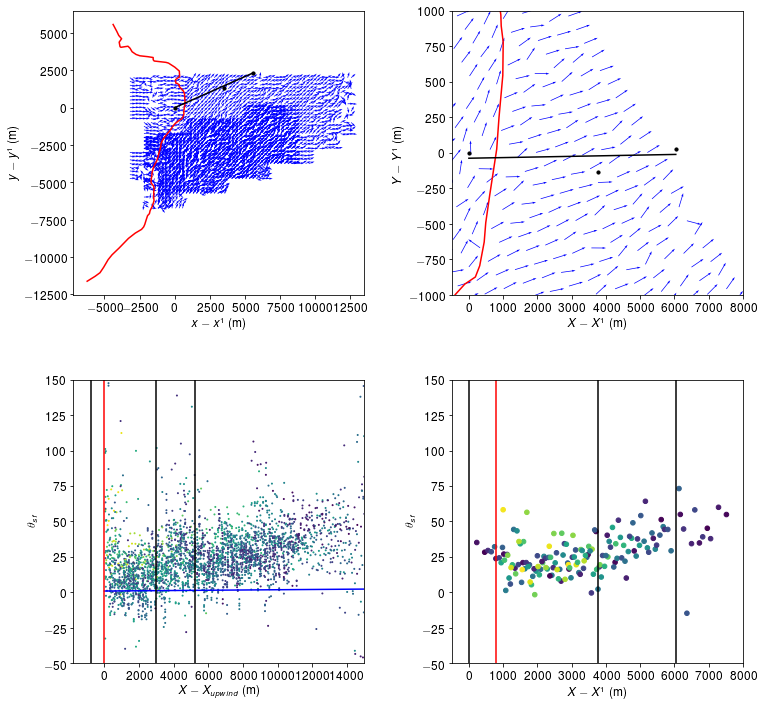

In [21]:
plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

S = 1
A = 0.2
LW = 0.8
LW2 = 2
fs = 12
SC = 100
v5 = 0
v6 = 0.7

lpu1 = 0
hpu1 = 25

fig = plt.gcf()

ax1 = plt.subplot(221)

sc1 = ax1.quiver(xmid,ymid,ar_x,ar_y,scale=50,color='b')

upwind = LineCollection([upwind_margin], alpha=1,color='r')
sc2 = ax1.add_collection(upwind)

x_temp = np.asarray([x_1,x_3])
y_temp = met_dir[0]*x_temp
sc1 = ax1.plot(x_temp,y_temp,c='k')
sc1 = ax1.scatter([x_1,x_2,x_3],[y_1,y_2,y_3],c='k',s=10)
         
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1.set_xlabel('$x-x^{1}$ (m)',fontsize=fs)
ax1.set_ylabel('$y-y^{1}$ (m)',fontsize=fs)

ax1 = plt.subplot(222)

sc1 = ax1.quiver(Xmid,Ymid,Ar_x,Ar_y,scale=20,color='b')

Upwind = LineCollection([Upwind_margin], alpha=1,color='r')
sc2 = ax1.add_collection(Upwind)

X_temp = np.asarray([X_1,X_3])
Y_temp = np.asarray([Y_1+met_dir[1],Y_3+met_dir[1]])
sc1 = ax1.plot(X_temp,Y_temp,c='k')
sc1 = ax1.scatter([X_1,X_2,X_3],[Y_1,Y_2,Y_3],c='k',s=10)

plt.ylim(-10**3,10**3)
plt.xlim(X_1-500,8000)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1.set_xlabel('$X-X^{1}$ (m)',fontsize=fs)
ax1.set_ylabel('$Y-Y^{1}$ (m)',fontsize=fs)

ax1 = plt.subplot(223)

sc1 = ax1.scatter(Xmid_um[Xmid_um>0],DD[Xmid_um>0]+90,c=Ymid[Xmid_um>0],s=S)

X_temp = np.asarray([0,15000])
Y_temp = dune_ori[0]*X_temp+dune_ori[1]
sc1 = ax1.plot(X_temp,Y_temp,c='b')

sc1 = ax1.plot([X_1+X1_um,X_1+X1_um],[-50,150],c='k')
sc1 = ax1.plot([X_2+X1_um,X_2+X1_um],[-50,150],c='k')
sc1 = ax1.plot([X_3+X1_um,X_3+X1_um],[-50,150],c='k')
sc1 = ax1.plot([0,0],[-50,150],c='r')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.ylim(-50,150)
plt.xlim(X_1+X1_um-1000,15000)

ax1.set_xlabel('$X-X_{upwind}$ (m)',fontsize=fs)
ax1.set_ylabel('$\\theta_{sf}$',fontsize=fs)

ax1 = plt.subplot(224)

sc1 = ax1.scatter(Xmid[(Ymid>-1000)&(Ymid<1000)&(Xmid_um>0)],DD[(Ymid>-1000)&(Ymid<1000)&(Xmid_um>0)]+90,c=Ymid[(Ymid>-1000)&(Ymid<1000)&(Xmid_um>0)],s=S+20)

sc1 = ax1.plot([X_1,X_1],[-50,150],c='k')
sc1 = ax1.plot([X_2,X_2],[-50,150],c='k')
sc1 = ax1.plot([X_3,X_3],[-50,150],c='k')
sc1 = ax1.plot([-X1_um,-X1_um],[-50,150],c='r')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.ylim(-50,150)
plt.xlim(X_1-500,8000)

ax1.set_xlabel('$X-X^{1}$ (m)',fontsize=fs)
ax1.set_ylabel('$\\theta_{sf}$',fontsize=fs)

fig.subplots_adjust(wspace=0.3)
fig.subplots_adjust(hspace=0.3)

fig.set_size_inches(12, 12, forward=True)
# plt.savefig('some_name6.png', bbox_inches='tight',dpi=300)

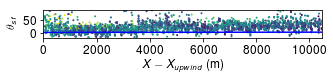

In [31]:
plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

S = 1
A = 0.2
LW = 0.8
LW2 = 2
fs = 12
SC = 100
v5 = 0
v6 = 0.7

lpu1 = 0
hpu1 = 25

fig = plt.gcf()

ax1 = plt.subplot(111)

sc1 = ax1.scatter(Xmid_um[Xmid_um>0],DD[Xmid_um>0]+90,c=Ymid[Xmid_um>0],s=S)

X_temp = np.asarray([0,15000])
Y_temp = dune_ori[0]*X_temp+dune_ori[1]
sc1 = ax1.plot(X_temp,Y_temp,c='b')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.ylim(-20,90)
plt.xlim(0,10500)

ax1.set_xlabel('$X-X_{upwind}$ (m)',fontsize=fs)
ax1.set_ylabel('$\\theta_{sf}$',fontsize=fs)

fig.set_size_inches(5, 0.5, forward=True)
plt.savefig('some_name9.png', bbox_inches='tight',dpi=300)

In [22]:
%store Xmid_um
%store DD

Stored 'Xmid_um' (ndarray)
Stored 'DD' (ndarray)


In [ ]:
image = misc.imread("/home/andrew/Documents/Python/WS_DEM/NM10_Kocurek/ot_379000_3631000.png")

dzdx = filters.sobel_h(image[:,:,0],mask=image[:,:,0]!=0) #gotta add this for the opentopo ones
dzdy = filters.sobel_v(image[:,:,0],mask=image[:,:,0]!=0)

slopethr = 0.018

ae = np.arctan(dzdy/dzdx)*180/np.pi

dzdy_b = np.copy(dzdy)
dzdx_b = np.copy(dzdx)
dzdx_b[(dzdx_b**2+dzdy_b**2)**0.5<slopethr] = np.nan
dzdy_b[(dzdx_b**2+dzdy_b**2)**0.5<slopethr] = np.nan

ae_b = np.arctan2(dzdy_b,dzdx_b)*180/np.pi

sfa = ae_b[~np.isnan(ae_b)]
dd  = np.mean(sfa)

In [545]:
image = misc.imread("/home/andrew/Documents/Python/WS_DEM/NM09_09Kocurek/ot_379000_3631000_1.png")

dzdx = filters.sobel_h(image[:,:,0],mask=image[:,:,0]!=0) #gotta add this for the opentopo ones
dzdy = filters.sobel_v(image[:,:,0],mask=image[:,:,0]!=0)

slopethr = 0.018

ae = np.arctan(dzdy/dzdx)*180/np.pi

dzdy_b = np.copy(dzdy)
dzdx_b = np.copy(dzdx)
dzdx_b[(dzdx_b**2+dzdy_b**2)**0.5<slopethr] = np.nan
dzdy_b[(dzdx_b**2+dzdy_b**2)**0.5<slopethr] = np.nan

ae_b = np.arctan2(dzdy_b,dzdx_b)*180/np.pi

sfa = ae_b[~np.isnan(ae_b)]
dd  = np.mean(sfa)

In [375]:
image = misc.imread("/home/andrew/Documents/Python/WS_DEM/NM09_01Kocurek/ot_024_000013_1.png")

dzdx = filters.sobel_h(image[:,:,0]) #gotta add this for the opentopo ones
dzdy = filters.sobel_v(image[:,:,0])

slopethr = 0.018

ae = np.arctan(dzdy/dzdx)*180/np.pi

dzdy_b = np.copy(dzdy)
dzdx_b = np.copy(dzdx)
dzdx_b[(dzdx_b**2+dzdy_b**2)**0.5<slopethr] = np.nan
dzdy_b[(dzdx_b**2+dzdy_b**2)**0.5<slopethr] = np.nan

ae_b = np.arctan2(dzdy_b,dzdx_b)*180/np.pi

sfa = ae_b[~np.isnan(ae_b)]
dd  = np.mean(sfa)

In [640]:
image = misc.imread("/home/andrew/Documents/Python/WS_DEM/DEM_IMG_TIFF/13SCS820360.png")

dzdx = filters.sobel_h(image)
dzdy = filters.sobel_v(image)

slopethr = 0.018

ae = np.arctan(dzdy/dzdx)*180/np.pi

dzdy_b = np.copy(dzdy)
dzdx_b = np.copy(dzdx)
dzdx_b[(dzdx_b**2+dzdy_b**2)**0.5<slopethr] = np.nan
dzdy_b[(dzdx_b**2+dzdy_b**2)**0.5<slopethr] = np.nan

ae_b = np.arctan2(dzdy_b,dzdx_b)*180/np.pi

sfa = ae_b[~np.isnan(ae_b)]
dd  = np.mean(sfa)

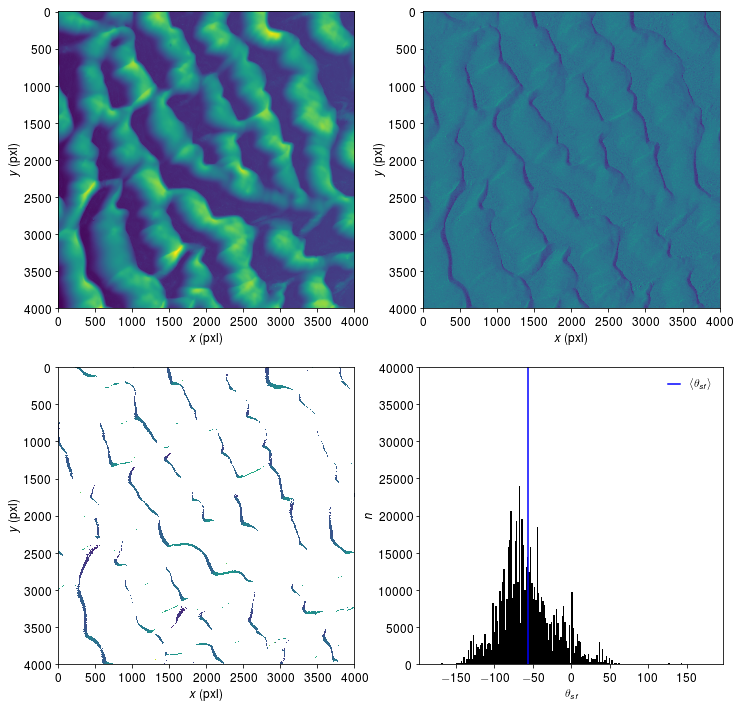

In [641]:
plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

S = 3
A = 0.2
LW = 0.8
LW2 = 2
fs = 12
SC = 100
v5 = 0
v6 = 0.7

lpu1 = 0
hpu1 = 25

fig = plt.gcf()

ax1 = plt.subplot(221)

# temp = np.copy(image[:,:,0])
# temp[temp==0] = -1

# sc1 = ax1.imshow(temp)

sc1 = ax1.imshow(image)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1.set_xlabel('$x$ (pxl)',fontsize=fs)
ax1.set_ylabel('$y$ (pxl)',fontsize=fs)

ax2 = plt.subplot(222)

sc1 = ax2.imshow(dzdy)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax2.set_xlabel('$x$ (pxl)',fontsize=fs)
ax2.set_ylabel('$y$ (pxl)',fontsize=fs)

ax3 = plt.subplot(223)

sc1 = ax3.imshow(ae_b)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax3.set_xlabel('$x$ (pxl)',fontsize=fs)
ax3.set_ylabel('$y$ (pxl)',fontsize=fs)

ax4 = plt.subplot(224)

sc1 = ax4.hist(sfa,bins=200,color='k')
sc1 = ax4.plot([dd,dd],[0,4*10**4],c='b',label='$\\langle\\theta_{sf}\\rangle$')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

l = ax4.legend(loc=0,frameon=False,ncol=3,fontsize=fs,handlelength=1)

plt.ylim(0,40000)

ax4.set_xlabel('$\\theta_{sf}$',fontsize=fs)
ax4.set_ylabel('$n$',fontsize=fs)

fig.subplots_adjust(wspace=0.2)
fig.subplots_adjust(hspace=0.2)

fig.set_size_inches(12, 12, forward=True)
plt.savefig('some_name7.png', bbox_inches='tight',dpi=300)